In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
%matplotlib notebook

In [4]:
scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
# plot.draw() 


In [5]:
import random
import math

def generate_cloud_of_points(xMin, xMax, yMin, yMax, numberOfPoints):
    arr = []
    for i in range(numberOfPoints):
        x = random.uniform(xMin,xMax)
        y = random.uniform(yMin,yMax)
        arr.append([x,y])
    return arr

def create_circe(X, Y, R, points=720):
    arr = []
    accuracy = (math.pi*4)/points
    for i in range(points):
        x = R * math.sin(i * accuracy) + X
        y = R * math.cos(i * accuracy) + Y
        arr.append([x,y])
    return arr

In [6]:
def dist(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [7]:
cloud = generate_cloud_of_points(0,100,0,100,50)
circle = create_circe(0, 0, 100)

plot = Plot([Scene([PointsCollection(cloud), PointsCollection(circle, color = 'red', marker = '.')],[])])
# plot.draw()

In [8]:
cloud = generate_cloud_of_points(0,100,0,100,100)

[[0.6870966347529817, 91.11644833122851], [99.33705337883734, 26.856676158084813]]


<IPython.core.display.Javascript object>


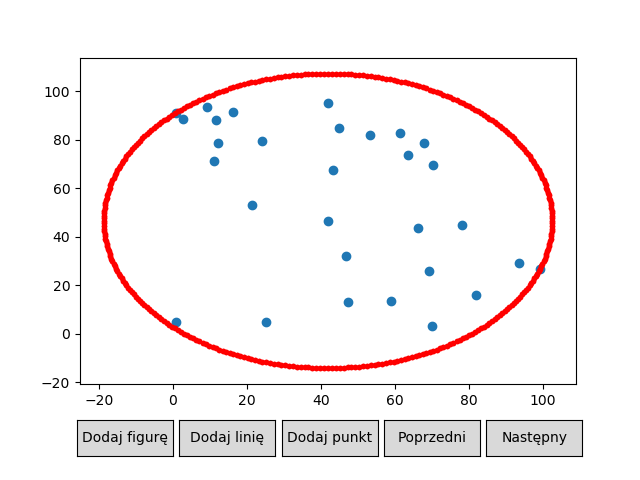

In [11]:
def minimal_area_circle(cloud):
    center_point = cloud[0]
    R = 0
    j = 0
    for i in range(1, len(cloud)):
        dis = dist(center_point, cloud[i])
        if R < dis:
            R = dis
            j = i
    circle = create_circe(center_point[0], center_point[1], R)
    
    
    return circle, j, R

def length_of_vector(vector):
    return math.sqrt(vector[0]**2 + vector[1]**2)

def step_vector(center_point, edge_point, steps=10000):
    return [(edge_point[0]-center_point[0])/steps, (edge_point[1]-center_point[1])/steps]


def detect_if_point_is_on_circle(point, X, Y, R, eps = 10**(-3)):
    x = point[0]
    y = point[1]
    
#     return (math.sqrt((x-X)**2 + (y-Y)**2) - R < eps) and (math.sqrt((x-X)**2 + (y-Y)**2) - R > -eps)
    return math.sqrt((x-X)**2 + (y-Y)**2) >= R


def decrease_cricle(center_point, R, vector):
    center_point[0] += vector[0]
    center_point[1] += vector[1]
    R += -length_of_vector(vector)
    
    return R


def points_on_circle(center_point, R, points):
    on_circle = []
    
    for point in points:
        if(detect_if_point_is_on_circle(point, center_point[0], center_point[1], R)):
            on_circle.append(point)
    return on_circle
    
    
def find_second_point(center_point, edge_point, R, points, scenes):
    vector = step_vector(center_point, edge_point)
    
    while(len(points_on_circle(center_point, R, points)) <= 1):
#         print(center_point, R)
        R = decrease_cricle(center_point, R, vector)
#         scenes.append(Scene([PointsCollection(cloud), 
#                              PointsCollection(create_circe(center_point[0], center_point[1], R), color = 'red', marker = '.')],[]))
        
    
    on_circle = points_on_circle(center_point, R, points)
    print(on_circle)
    
    return R
    
        
    
    


cloud = generate_cloud_of_points(0,100,0,100,30)

circle, j, R = minimal_area_circle(cloud)

center_point = cloud[0]
edge_point = cloud[j]

scenes = [Scene([PointsCollection(cloud), PointsCollection(circle, color = 'red', marker = '.'), PointsCollection([center_point,edge_point])],[])]

# print(step_vector(cloud[0], cloud[j]))

R = find_second_point(center_point, edge_point, R, cloud, scenes)

scenes.append(Scene([PointsCollection(cloud), PointsCollection(create_circe(center_point[0], center_point[1], R), color = 'red', marker = '.')],[]))

# print(center_point, R)

plot = Plot(scenes)
plot.draw()

In [ ]:
# def line_crossing_between_both_points(point1, point2):
#     xa=point1[0]
#     ya=point1[1]
    
#     xb=point2[0]
#     yb=point2[1]
    
#     if xa-xb == 0:
#         return 0, ya
#     A = ya-yb/xa-xb
#     B = ya - A*xa
    
#     return A, B